<h1> Import libraries and prepare the dataset </h1>

In [17]:
import pandas as pd 
import numpy as np 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score as r2
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.sandbox.regression.predstd import wls_prediction_std

# LOADING THE DATASET
train_df = pd.read_excel('new_train_data.xlsx')
test_df = pd.read_excel('new_test_data.xlsx')


In [2]:
train_df = train_df.drop(['Id', 'latitude', 'longitude'], axis = 1)
train_df = train_df.fillna(0)

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1620 entries, 0 to 1619
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   type                          1620 non-null   object 
 1   no_of_rooms                   1620 non-null   float64
 2   city                          1620 non-null   object 
 3   value                         1620 non-null   int64  
 4   inner_surface                 1620 non-null   float64
 5   land_surface                  1620 non-null   float64
 6   population                    1620 non-null   int64  
 7   pop_density                   1620 non-null   float64
 8   no_of_schools                 1620 non-null   int64  
 9   air_quality                   1620 non-null   int64  
 10  distance_from_the_sea         1620 non-null   int64  
 11  average_income                1620 non-null   int64  
 12  proximity_to_nearest_airport  1620 non-null   int64  
dtypes: 

In [4]:
# Change the data types in some columns from decimal to integer

train_df = train_df.astype({"no_of_rooms":'int64', "value":'int64' , "inner_surface":'int64', "land_surface":'int64', "pop_density":'int64'})

In [5]:
train_df.head()

,type,no_of_rooms,city,value,inner_surface,land_surface,population,pop_density,no_of_schools,air_quality,distance_from_the_sea,average_income,proximity_to_nearest_airport
0,Terrain,0,Troyes,2000,0,301,62812,4683,63,28,305,38448,54
1,Terrain,0,Cluny,2500,0,190,4803,200,6,9,400,30000,86
2,Maison,5,√àze,2820,222,4102,2343,240,2,13,8,40935,14
3,Terrain,0,Chamonix-Mont-Blanc,3000,0,37,8906,78,11,18,350,36000,90
4,Appartement,3,Troyes,3500,100,0,62812,4683,63,28,305,38448,54


In [6]:
# Separate the train dataframe into dataframes for each property type

hs_train = train_df.loc[train_df['type'] == "Maison"]
ap_train = train_df.loc[train_df['type'] == "Appartement"].drop(['land_surface'], axis=1)
tn_train = train_df.loc[train_df['type'] == "Terrain"].drop(['no_of_rooms', 'inner_surface'], axis=1)

In [7]:
test_df = test_df.drop(['latitude', 'longitude'], axis = 1)
test_df = test_df.fillna(0)

In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172 entries, 0 to 171
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   type                          172 non-null    object 
 1   no_of_rooms                   172 non-null    float64
 2   city                          172 non-null    object 
 3   value                         172 non-null    int64  
 4   inner_surface                 172 non-null    float64
 5   land_surface                  172 non-null    float64
 6   population                    172 non-null    int64  
 7   pop_density                   172 non-null    int64  
 8   no_of_schools                 172 non-null    int64  
 9   air_quality                   172 non-null    int64  
 10  distance_from_the_sea         172 non-null    float64
 11  average_income                172 non-null    int64  
 12  proximity_to_nearest_airport  172 non-null    float64
dtypes: fl

In [9]:
# Change the data types in some columns from decimal to integer

test_df = test_df.astype({"no_of_rooms":'int64', "value":'int64' , "inner_surface":'int64', "land_surface":'int64', "pop_density":'int64'})

In [10]:
test_df.head()

,type,no_of_rooms,city,value,inner_surface,land_surface,population,pop_density,no_of_schools,air_quality,distance_from_the_sea,average_income,proximity_to_nearest_airport
0,Appartement,4,La Garde,4900000,87,16105,25380,1600,14,29,3.6,31000,35.6
1,Maison,5,La Garde,756710,147,952,25380,1600,14,29,3.6,31000,35.6
2,Maison,3,La Garde,675000,77,1060,25380,1600,14,29,3.6,31000,35.6
3,Maison,6,La Garde,530000,150,648,25380,1600,14,29,3.6,31000,35.6
4,Maison,5,La Garde,529500,126,545,25380,1600,14,29,3.6,31000,35.6


In [11]:
# Separate the test dataframe into dataframes for each property type

hs_test = test_df.loc[test_df['type'] == "Maison"]
ap_test = test_df.loc[test_df['type'] == "Appartement"].drop(['land_surface'], axis=1)
tn_test = test_df.loc[test_df['type'] == "Terrain"].drop(['no_of_rooms', 'inner_surface'], axis=1)

<h1> House predictions and modelling </h1>

In [12]:
hs_train.describe()

,no_of_rooms,value,inner_surface,land_surface,population,pop_density,no_of_schools,air_quality,distance_from_the_sea,average_income,proximity_to_nearest_airport
count,347.000000,3.470000e+02,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000
mean,4.484150,8.148404e+05,115.752161,2109.259366,55420.899135,1514.475504,50.504323,28.867435,138.792507,38924.729107,41.913545
std,1.707399,2.943041e+06,63.772507,13059.738041,51538.956739,1515.108188,44.416081,15.109992,164.501446,3320.156304,24.388558
min,1.000000,2.820000e+03,6.000000,0.000000,1878.000000,69.000000,2.000000,9.000000,1.000000,30000.000000,8.000000
25%,4.000000,1.460000e+05,79.000000,153.000000,2343.000000,200.000000,3.000000,13.000000,1.000000,38448.000000,15.000000
50%,4.000000,2.350000e+05,102.000000,371.000000,62812.000000,930.000000,63.000000,28.000000,45.000000,40171.000000,39.000000
75%,5.000000,5.829250e+05,140.000000,855.000000,88876.000000,2000.000000,87.000000,51.000000,305.000000,41009.000000,54.000000
max,14.000000,3.245841e+07,521.000000,202573.000000,156854.000000,4683.000000,127.000000,51.000000,474.000000,41883.000000,90.000000


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

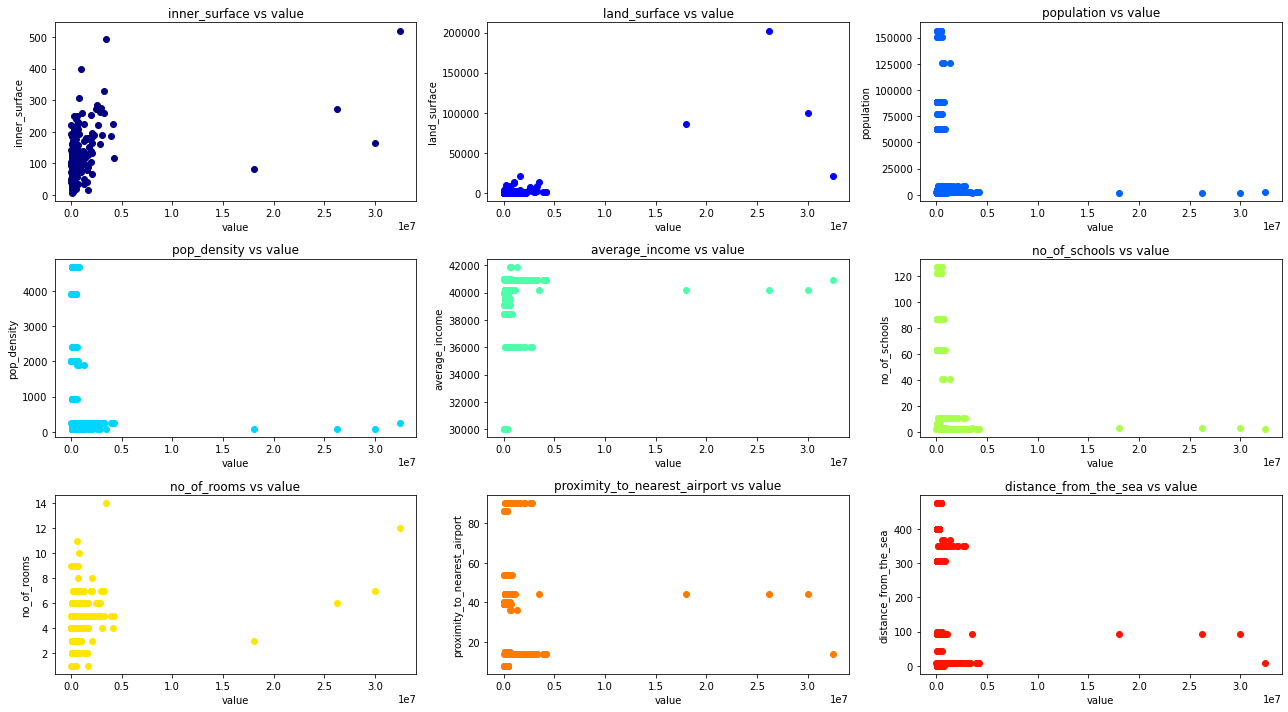

In [13]:
jet= plt.get_cmap('jet')
colors = iter(jet(np.linspace(0,1,10)))
 
def correlation_plot(df,variables, n_rows, n_cols):
    #fig = plt.figure(figsize=(8,6))
    fig = plt.figure(figsize=(18,10))
    for i, var in enumerate(variables):
        ax = fig.add_subplot(n_rows,n_cols,i+1)
        asset = df.loc[:,var]
        ax.scatter(df["value"], asset, c = next(colors))
        ax.set_xlabel("value")
        ax.set_ylabel("{}".format(var))
        ax.set_title(var +" vs value")
    fig.tight_layout() 
    plt.show()
        
# Take the name of the last 6 columns of the SPY_data which are the model features  
variables = hs_train[['inner_surface', 'land_surface', 'population', 'pop_density', 'average_income', 'no_of_schools', 'no_of_rooms',  'proximity_to_nearest_airport', 'distance_from_the_sea']].columns

correlation_plot(hs_train,variables,3,3)

In [48]:
# Feature selection and data split

X_var = hs_train[['inner_surface', 'land_surface']].values
y_var = hs_train['value'].values
X_train, X_test, y_train, y_test = train_test_split(X_var, y_var, test_size = 0.2, random_state = 0)

In [43]:
housing_model = ols("""value ~ inner_surface 
                                + land_surface """, data=hs_train).fit()
housing_model.summary()    

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     328.7
Date:                Sun, 21 Mar 2021   Prob (F-statistic):           1.55e-80
Time:                        14:33:25   Log-Likelihood:                -5475.0
No. Observations:                 347   AIC:                         1.096e+04
Df Residuals:                     344   BIC:                         1.097e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -8.558e+05   1.93e+05     -4.424      0.000   -1.24e+06   -4.75e+05
inner_surface  1.145e+04   1485.339      7.711      0.000    8531.993    1.44e+04
land_surface    163.5268      7.253     22.546      0.000     149.261     177.793
==============================================================================
Omnibus:                      551.500   Durbin-Watson:                   1.067
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           194080.612
Skew:                           8.331   Prob(JB):                         0.00
Kurtosis:                     117.655   Cond. No.                     2.75e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.75e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

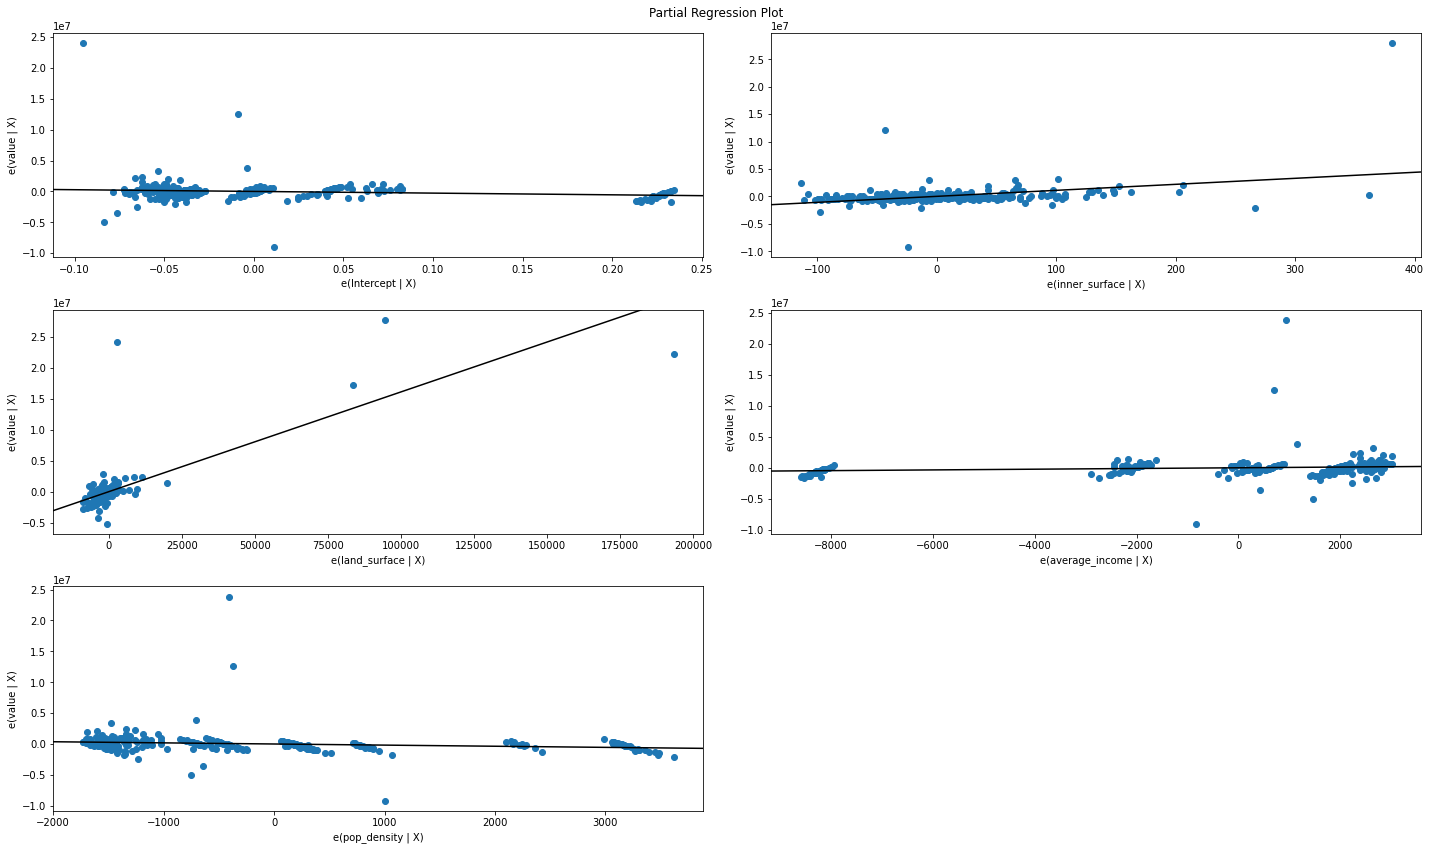

In [39]:
fig = plt.figure(figsize=(20,12))
fig = sm.graphics.plot_partregress_grid(housing_model, fig=fig)

In [49]:
lr = LinearRegression()
lr_fit = lr.fit(X_train, y_train)
lr_yhat = lr.predict(X_test)

In [50]:
# The Mean Absolute Error

mae = sum(abs(lr_yhat - y_test)) / hs_train.shape[0]

print('Mean absolute error: ' + str(round(mae,2)))

# The Mean Squared Error
print('sqrt(Mean squared error): %.2f'
      % np.sqrt(mean_squared_error(y_test, lr_yhat)))

# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2(y_test, lr_yhat))

#Variance Score
print('Variance score: {}'.format(lr.score(X_test, y_test)))

# Estmated equation
print('Estimated equation is: (',lr_fit.coef_,') X + (',lr_fit.intercept_,')')

Mean absolute error: 137541.68
sqrt(Mean squared error): 1047964.52
Coefficient of determination: -2.56
Variance score: -2.557143833309308
Estimated equation is: ( [13909.53301447   162.74541432] ) X + ( -1110752.590774447 )


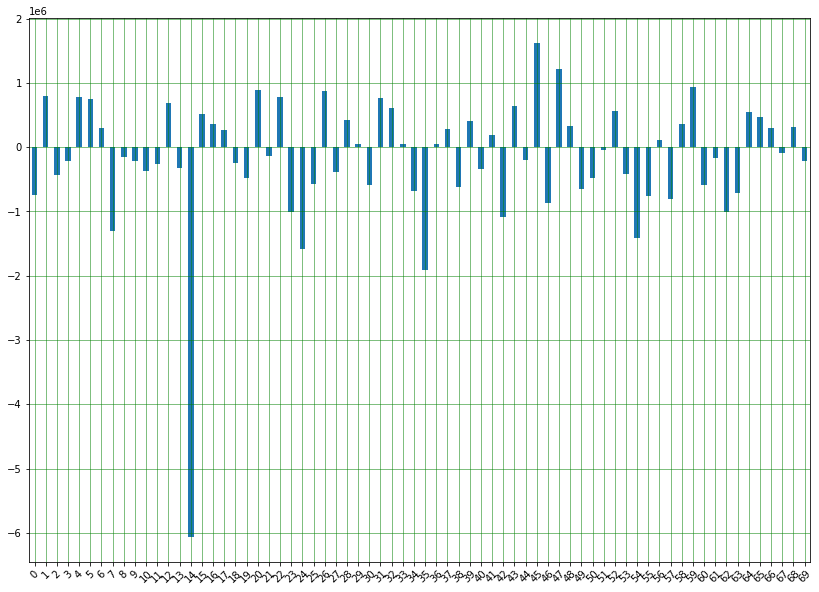

In [21]:
# Dataframe that outputs the actual and the predicted values

df_pred = pd.DataFrame({'Actual': y_test, 'Predicted': lr_yhat})

# Calculate the error

error = df_pred['Actual'] - df_pred['Predicted']
 
# Plot the error term between the actual and predicted values
 
error.plot(kind='bar',figsize=(14,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.xticks(rotation=45)
plt.show()

In [361]:
# Find the huge error in the dataset

hs_train.loc[hs_train['value'] == df_pred['Actual'].iloc[47]]

,type,no_of_rooms,city,value,inner_surface,land_surface,latitude,longitude,population,pop_density,no_of_schools,air_quality,distance_from_the_sea,average_income,proximity_to_nearest_airport
1522,Maison,12,√àze,32458408,521,21160,43.728892,7.36207,2343,240,2,13,8,40935,14


In [22]:
# Feature selection and data split

X_train = hs_train[['inner_surface', 'land_surface', 'population', 'average_income', 'no_of_schools', 'proximity_to_nearest_airport']].values
y_train = hs_train['value'].values
X_test = hs_test[['inner_surface', 'land_surface', 'population', 'average_income', 'no_of_schools', 'proximity_to_nearest_airport']].values
y_test = hs_test['value'].values

In [23]:
lr = LinearRegression()
lr_fit = lr.fit(X_train, y_train)
lr_yhat = lr.predict(X_test)

In [24]:
# Ridge

ridge = Ridge(alpha = 0.5)
ridge_fit = ridge.fit(X_train, y_train)
ridge_yhat = ridge.predict(X_test)

# Lasso

lasso = Lasso(alpha = 0.01)
lasso.fit(X_train, y_train)
lasso_yhat = lasso.predict(X_test)

# Bayesian

bayesian = BayesianRidge()
bayesian.fit(X_train, y_train)
bayesian_yhat = bayesian.predict(X_test)

# ElasticNet

en = ElasticNet(alpha = 0.01)
en.fit(X_train, y_train)
en_yhat = en.predict(X_test)

NameError: name 'Ridge' is not defined

In [772]:
print('EXPLAINED VARIANCE SCORE:')
print('Explained Variance Score of Ridge model is {}'.format(evs(y_test, ridge_yhat)))
print('Explained Variance Score of Lasso model is {}'.format(evs(y_test, lasso_yhat)))
print('Explained Variance Score of Bayesian model is {}'.format(evs(y_test, bayesian_yhat)))
print('Explained Variance Score of ElasticNet is {}'.format(evs(y_test, en_yhat)))

EXPLAINED VARIANCE SCORE:
Explained Variance Score of Ridge model is -8.954478305838341
Explained Variance Score of Lasso model is -8.954376967202105
Explained Variance Score of Bayesian model is -22.892537819114526
Explained Variance Score of ElasticNet is -8.954728405761108


In [25]:
# The Mean Absolute Error

mae = sum(abs(lr_yhat - y_test)) / hs_test.shape[0]

print('Mean absolute error: ' + str(round(mae,2)))

# The Mean Squared Error
print('sqrt(Mean squared error): %.2f'
      % np.sqrt(mean_squared_error(y_test, lr_yhat)))

# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2(y_test, lr_yhat))

#Variance Score
print('Variance score: {}'.format(lr.score(X_test, y_test)))

# Estmated equation
print('Estimated equation is: (',lr_fit.coef_,') X + (',lr_fit.intercept_,')')

Mean absolute error: 385577.94
sqrt(Mean squared error): 534138.48
Coefficient of determination: -10.29
Variance score: -10.288228661763009
Estimated equation is: ( [ 1.02602667e+04  1.61238130e+02  4.63087119e+00  4.57158321e+01
 -1.15998644e+04 -3.89760447e+03] ) X + ( -1999818.3655320983 )


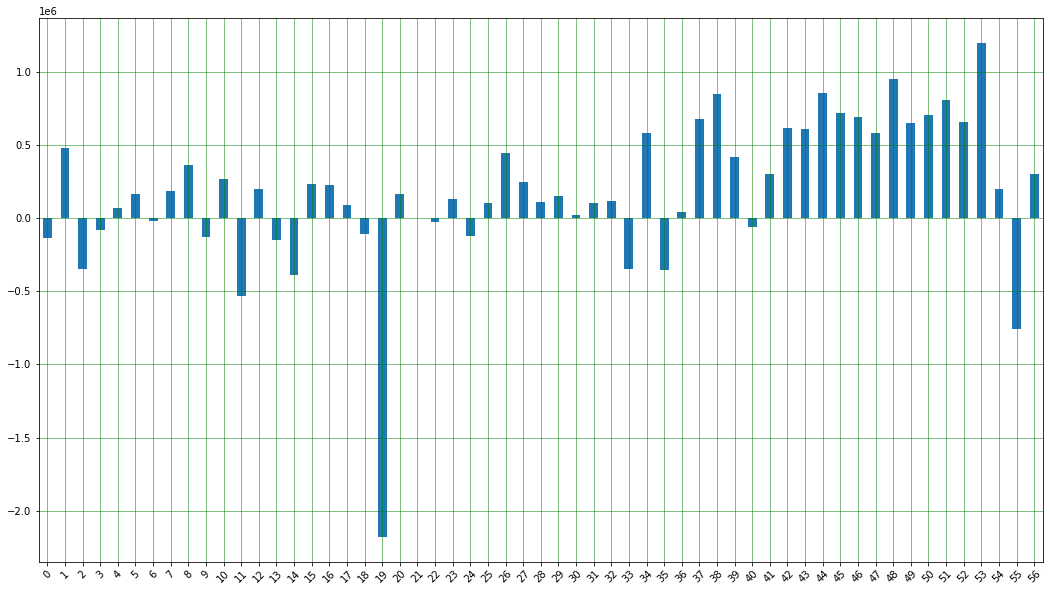

In [26]:
# Dataframe that outputs the actual and the predicted values
df_pred = pd.DataFrame({'Actual': y_test, 'Predicted': lr_yhat})

error = df_pred['Actual'] - df_pred['Predicted']
 
# Plot the error term between the actual and predicted values
 
error.plot(kind='bar',figsize=(18,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.xticks(rotation=45)
plt.show()

<h1> Terrain predictions and modeling </h1>

In [799]:
tn_train.describe()

,value,land_surface,population,pop_density,no_of_schools,air_quality,distance_from_the_sea,average_income,proximity_to_nearest_airport
count,8.600000e+01,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000
mean,6.857907e+05,4186.267442,32087.488372,786.872093,29.279070,23.127907,180.046512,37633.930233,51.744186
std,1.655621e+06,11843.194099,46965.128999,1191.391384,40.133791,13.285814,169.048960,4158.388743,28.977958
min,0.000000e+00,0.000000,1878.000000,69.000000,2.000000,9.000000,1.000000,30000.000000,8.000000
25%,1.045925e+04,84.000000,2343.000000,78.000000,3.000000,13.000000,8.000000,36000.000000,39.000000
50%,6.250000e+04,626.500000,4803.000000,200.000000,6.000000,18.000000,94.000000,40064.000000,44.000000
75%,6.537125e+05,1991.500000,62812.000000,930.000000,63.000000,29.000000,350.000000,40935.000000,86.000000
max,1.300000e+07,66370.000000,156854.000000,4683.000000,127.000000,51.000000,474.000000,41883.000000,90.000000


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

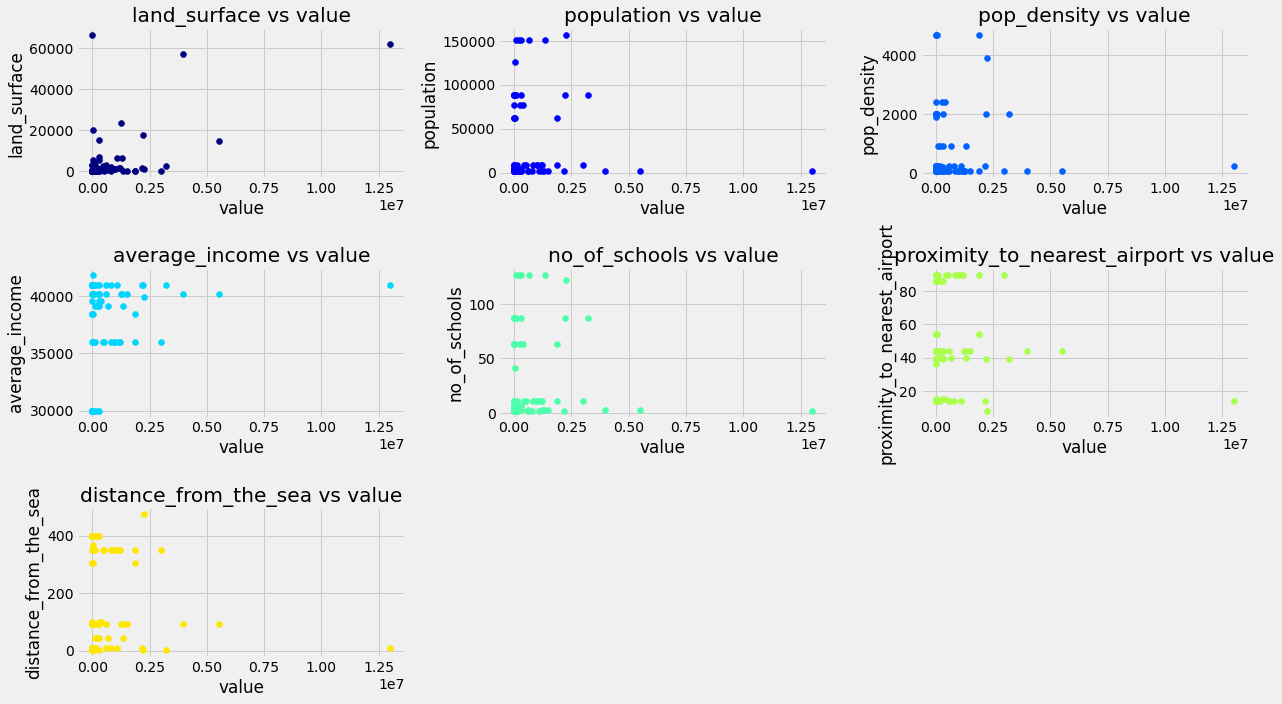

In [984]:
jet= plt.get_cmap('jet')
colors = iter(jet(np.linspace(0,1,10)))
 
def correlation_plot(df,variables, n_rows, n_cols):
    #fig = plt.figure(figsize=(8,6))
    fig = plt.figure(figsize=(18,10))
    for i, var in enumerate(variables):
        ax = fig.add_subplot(n_rows,n_cols,i+1)
        asset = df.loc[:,var]
        ax.scatter(df["value"], asset, c = next(colors))
        ax.set_xlabel("value")
        ax.set_ylabel("{}".format(var))
        ax.set_title(var +" vs value")
    fig.tight_layout() 
    plt.show()
        
# Take the name of the last 6 columns of the SPY_data which are the model features  
variables = tn_train[['land_surface', 'population', 'pop_density', 'average_income', 'no_of_schools',  'proximity_to_nearest_airport', 'distance_from_the_sea']].columns

correlation_plot(tn_train,variables,3,3)

In [817]:
terrain_model = ols("""value ~ land_surface 
                                + population
                                + average_income
                                + pop_density
                                + no_of_schools
                                + proximity_to_nearest_airport
                                + distance_from_the_sea""", data=hs_train).fit()
terrain_model.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                     80.56
Date:                Sun, 21 Mar 2021   Prob (F-statistic):           2.76e-68
Time:                        04:07:55   Log-Likelihood:                -5490.5
No. Observations:                 347   AIC:                         1.100e+04
Df Residuals:                     339   BIC:                         1.103e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                    -2.589e+06   2.93e+06     -0.884      0.377   -8.35e+06    3.17e+06
land_surface                   168.4702      7.619     22.113      0.000     153.485     183.456
population                      -6.3038     15.063     -0.419      0.676     -35.932      23.325
average_income                  98.6469     70.248      1.404      0.161     -39.530     236.824
pop_density                   -186.4683    134.051     -1.391      0.165    -450.145      77.209
no_of_schools                  613.3950   1.88e+04      0.033      0.974   -3.63e+04    3.75e+04
proximity_to_nearest_airport -9744.5033   7982.063     -1.221      0.223   -2.54e+04    5956.107
distance_from_the_sea         1568.7886   1641.504      0.956      0.340   -1660.028    4797.605
==============================================================================
Omnibus:                      634.672   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           397750.700
Skew:                          10.910   Prob(JB):                         0.00
Kurtosis:                     167.420   Cond. No.                     2.45e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.45e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

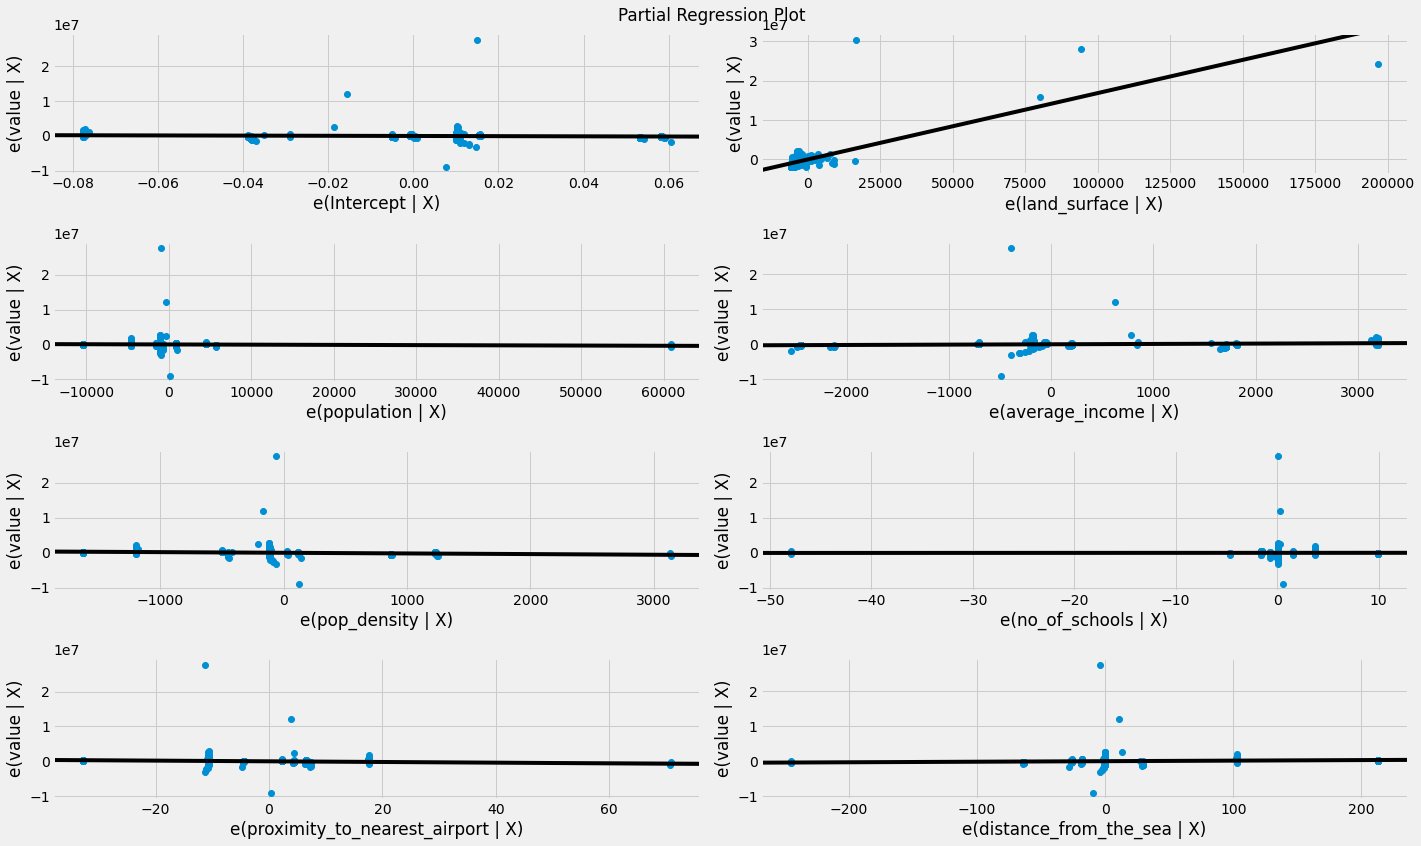

In [819]:
fig = plt.figure(figsize=(20,12))
fig = sm.graphics.plot_partregress_grid(terrain_model, fig=fig)

In [853]:
# FEATURE SELECTION & DATA SPLIT

X_var = tn_train[['land_surface', 'average_income']].values
y_var = tn_train['value'].values
X_train, X_test, y_train, y_test = train_test_split(X_var, y_var, test_size = 0.2, random_state = 0)

In [854]:
lr = LinearRegression()
lr_fit = lr.fit(X_train, y_train)
lr_yhat = lr.predict(X_test)

In [855]:
mae = sum(abs(lr_yhat - y_test)) / tn_train.shape[0]

print('Mean absolute error: ' + str(round(mae,2)))

# The mean squared error
print('sqrt(Mean squared error): %.2f'
      % np.sqrt(mean_squared_error(y_test, lr_yhat)))

# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2(y_test, lr_yhat))

#Variance Score
print('Variance score: {}'.format(lr.score(X_test, y_test)))

# Estmated equation
print('Estimated equation is: (',lr_fit.coef_,') X + (',lr_fit.intercept_,')')

Mean absolute error: 179840.89
sqrt(Mean squared error): 2140452.98
Coefficient of determination: -8.86
Variance score: -8.85599291449613
Estimated equation is: ( [127.16906604  15.81537541] ) X + ( -330675.10910455545 )


In [856]:
# Dataframe that outputs the actual and the predicted values
df_pred = pd.DataFrame({'Actual': y_test, 'Predicted': lr_yhat})

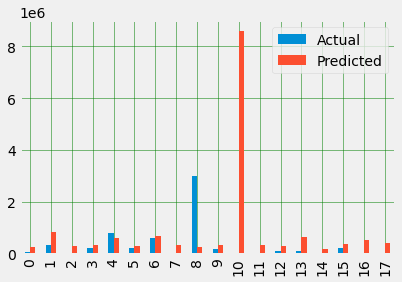

In [857]:
df1 = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': lr_yhat.flatten()})
df1 = df1.head(20)
df1.plot(kind='bar')
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

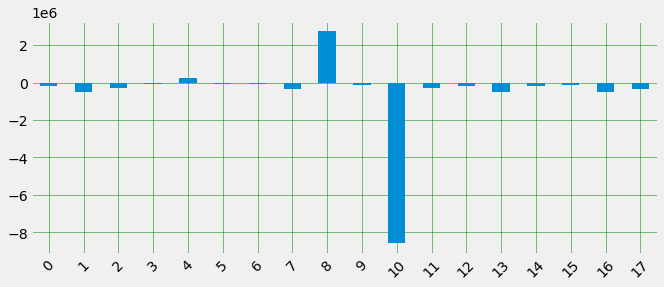

In [858]:
# Calculate the error

error = df_pred['Actual'] - df_pred['Predicted']
 
# Plot the error term between the actual and predicted values
 
error.plot(kind='bar',figsize=(10,4))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.xticks(rotation=45)
plt.show()

In [865]:
# Feature selection and data split

X_train = tn_train[['land_surface', 'average_income', 'population', 'pop_density', 'no_of_schools', 'proximity_to_nearest_airport', 'distance_from_the_sea']].values
y_train = tn_train['value'].values
X_test = tn_test[['land_surface', 'average_income', 'population', 'pop_density', 'no_of_schools',  'proximity_to_nearest_airport', 'distance_from_the_sea']].values
y_test = tn_test['value'].values

In [876]:
lr = LinearRegression()
lr_fit = lr.fit(X_train, y_train)
lr_yhat = lr.predict(X_test)

In [877]:
mae = sum(abs(lr_yhat - y_test)) / tn_test.shape[0]

print('Mean absolute error: ' + str(round(mae,2)))

# The mean squared error
print('sqrt(Mean squared error): %.2f'
      % np.sqrt(mean_squared_error(y_test, lr_yhat)))

# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2(y_test, lr_yhat))

#Variance Score
print('Variance score: {}'.format(lr.score(X_test, y_test)))

# Estmated equation
print('Estimated equation is: (',lr_fit.coef_,') X + (',lr_fit.intercept_,')')

Mean absolute error: 1013301.28
sqrt(Mean squared error): 1308400.90
Coefficient of determination: -492.44
Variance score: -492.4410448962661
Estimated equation is: ( [ 8.33444446e+01  2.07901245e+02 -3.11992126e+01 -3.84713253e+02
  4.29424335e+04 -1.89618485e+04  6.92168191e+03] ) X + ( -7705801.672019574 )


<h1> Apartment predictions and modelling </h1>

In [878]:
ap_train.describe()

,no_of_rooms,value,inner_surface,population,pop_density,no_of_schools,air_quality,distance_from_the_sea,average_income,proximity_to_nearest_airport
count,1197.000000,1.197000e+03,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000
mean,2.532164,2.201914e+05,57.598997,89821.953216,2040.632414,65.887218,25.074353,242.482038,39386.838764,38.928154
std,1.172430,3.414221e+05,30.091909,56688.596214,1559.278986,44.429172,9.350853,172.211100,2119.703781,26.125722
min,0.000000,1.000000e+00,1.000000,1878.000000,69.000000,2.000000,9.000000,1.000000,30000.000000,8.000000
25%,2.000000,8.000000e+04,36.000000,62812.000000,930.000000,41.000000,19.000000,45.000000,38448.000000,15.000000
50%,2.000000,1.340000e+05,54.000000,88876.000000,1900.000000,63.000000,22.000000,305.000000,39559.000000,36.000000
75%,3.000000,2.625000e+05,72.000000,150672.000000,3900.000000,122.000000,30.000000,366.000000,40935.000000,54.000000
max,9.000000,8.800000e+06,420.000000,156854.000000,4683.000000,127.000000,51.000000,474.000000,41883.000000,90.000000


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

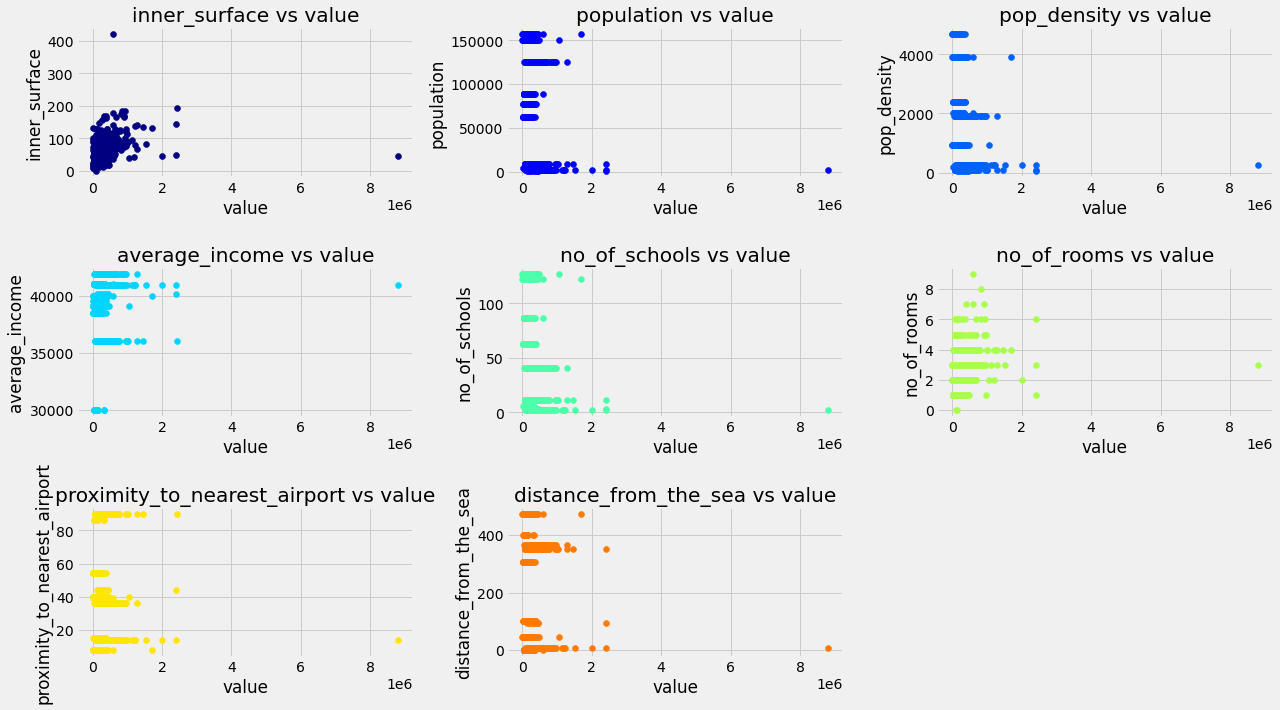

In [981]:
jet= plt.get_cmap('jet')
colors = iter(jet(np.linspace(0,1,10)))
 
def correlation_plot(df,variables, n_rows, n_cols):
    #fig = plt.figure(figsize=(8,6))
    fig = plt.figure(figsize=(18,10))
    for i, var in enumerate(variables):
        ax = fig.add_subplot(n_rows,n_cols,i+1)
        asset = df.loc[:,var]
        ax.scatter(df["value"], asset, c = next(colors))
        ax.set_xlabel("value")
        ax.set_ylabel("{}".format(var))
        ax.set_title(var +" vs value")
    fig.tight_layout() 
    plt.show()
        
# Take the name of the last 6 columns of the SPY_data which are the model features  
variables = ap_train[['inner_surface', 'population', 'pop_density', 'average_income', 'no_of_schools', 'no_of_rooms',  'proximity_to_nearest_airport', 'distance_from_the_sea']].columns

correlation_plot(ap_train,variables,3,3)

In [927]:
X_var = ap_train[['inner_surface','pop_density', 'population', 'no_of_schools', 'air_quality', 'average_income', 'distance_from_the_sea']].values
y_var = ap_train['value'].values
X_train, X_test, y_train, y_test = train_test_split(X_var, y_var, test_size = 0.2, random_state = 0)

In [928]:
lr = LinearRegression()
lr_fit = lr.fit(X_train, y_train)
lr_yhat = lr.predict(X_test)

In [929]:
# Mean Absolute Error

mae = sum(abs(lr_yhat - y_test)) / ap_train.shape[0]

print('Mean absolute error: ' + str(round(mae,2)))

# The mean squared error
print('sqrt(Mean squared error): %.2f'
      % np.sqrt(mean_squared_error(y_test, lr_yhat)))

# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2(y_test, lr_yhat))

Mean absolute error: 18846.56
sqrt(Mean squared error): 142306.55
Coefficient of determination: 0.53


In [930]:
# Dataframe that output the actual and the predicted values
df_pred = pd.DataFrame({'Actual': y_test, 'Predicted': lr_yhat})
new_df = df_pred.tail(50)

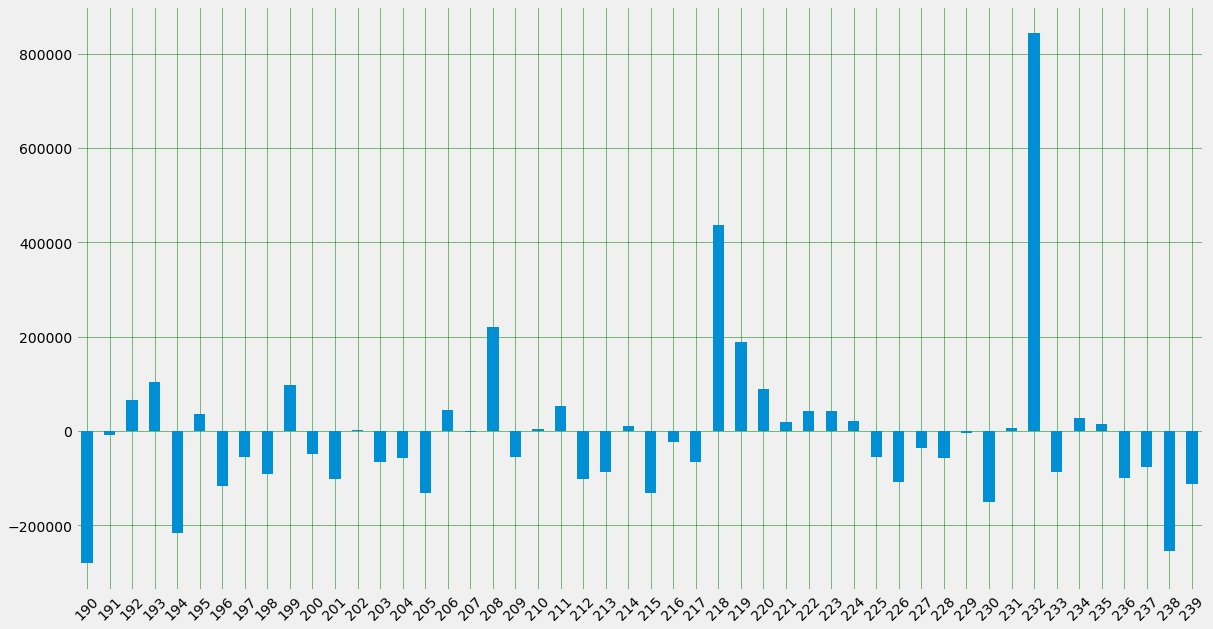

In [931]:
# Calculate error

error = new_df['Actual'] - new_df['Predicted']
 
# Plot the error term between the actual and predicted values
 
error.plot(kind='bar',figsize=(18,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.xticks(rotation=45)
plt.show()

In [899]:
# Find the huge error in the error graph

ap_train.loc[ap_train['value'] == df_pred['Actual'].iloc[232]]

,type,no_of_rooms,city,value,inner_surface,population,pop_density,no_of_schools,air_quality,distance_from_the_sea,average_income,proximity_to_nearest_airport
1555,Appartement,3,Èze,1525000,82,2343,240,2,13,8,40935,14


In [548]:
X_opt = X_test
regressor_OLS = sm.OLS(endog = y_test, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.192
Model:                            OLS   Adj. R-squared (uncentered):              0.175
Method:                 Least Squares   F-statistic:                              10.85
Date:                Sat, 20 Mar 2021   Prob (F-statistic):                    5.96e-05
Time:                        22:38:13   Log-Likelihood:                         -1348.8
No. Observations:                  93   AIC:                                      2702.
Df Residuals:                      91   BIC:                                      2707.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          4164.2280    957.302      4.350      0.000    2262.664    6065.792
x2         -1345.1215   1185.975     -1.134      0.260   -3700.916    1010.673
==============================================================================
Omnibus:                      196.694   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            28213.366
Skew:                           9.115   Prob(JB):                         0.00
Kurtosis:                      86.358   Cond. No.                         2.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [970]:
X_train = ap_train[['inner_surface', 'population', 'pop_density', 'average_income', 'no_of_schools', 'proximity_to_nearest_airport']].values
y_train = ap_train['value'].values
X_test = ap_test[['inner_surface', 'population', 'pop_density', 'average_income', 'no_of_schools', 'proximity_to_nearest_airport']].values
y_test = ap_test['value'].values

In [971]:
lr = LinearRegression()
lr_fit = lr.fit(X_train, y_train)
lr_yhat = lr.predict(X_test)

In [972]:
# Lasso

lasso = Lasso(alpha = 0.01)
lasso.fit(X_train, y_train)
lasso_yhat = lasso.predict(X_test)

In [973]:
# Mean Absolute Error

mae = sum(abs(lr_yhat - y_test)) / ap_test.shape[0]

print('Mean absolute error: ' + str(round(mae,2)))

# The mean squared error
print('sqrt(Mean squared error): %.2f'
      % np.sqrt(mean_squared_error(y_test, lr_yhat)))

# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2(y_test, lr_yhat))

Mean absolute error: 129421.61
sqrt(Mean squared error): 481297.03
Coefficient of determination: 0.05


In [974]:
# Mean Absolute Error

mae = sum(abs(lasso_yhat - y_test)) / ap_test.shape[0]

print('Mean absolute error: ' + str(round(mae,2)))

# The mean squared error
print('sqrt(Mean squared error): %.2f'
      % np.sqrt(mean_squared_error(y_test, lasso_yhat)))

# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2(y_test, lasso_yhat))

Mean absolute error: 129421.61
sqrt(Mean squared error): 481297.03
Coefficient of determination: 0.05


In [979]:
# Dataframe that output the actual and the predicted values
df_pred = pd.DataFrame({'Actual': y_test, 'Predicted': lasso_yhat})
new_df = df_pred.tail(50)

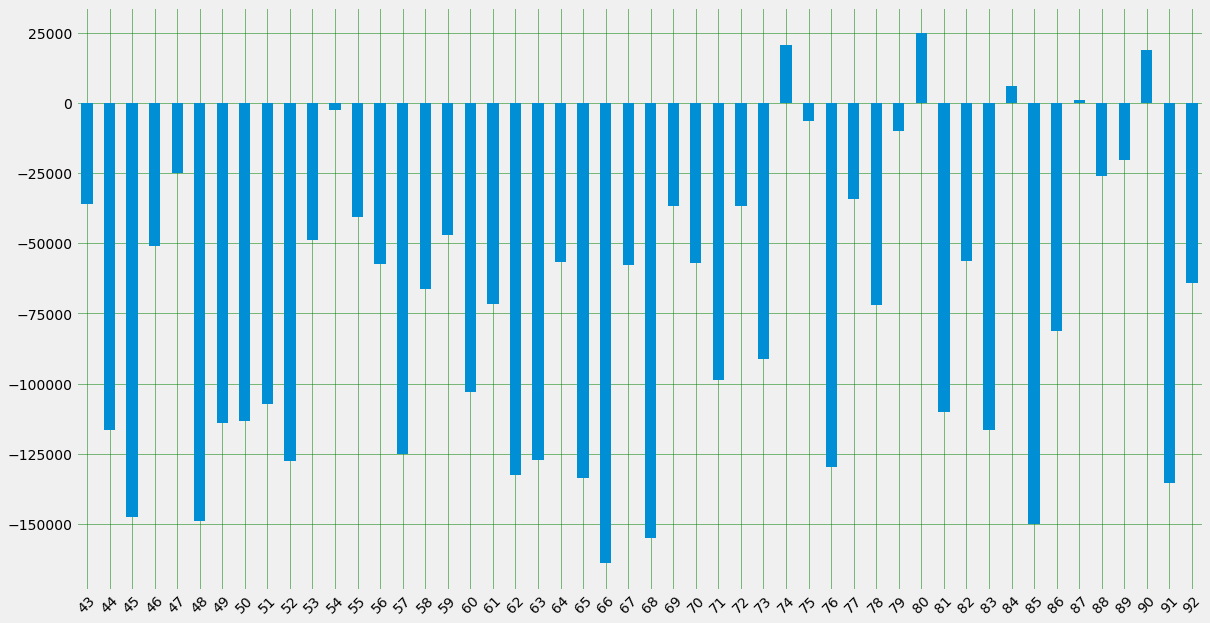

In [980]:
# Calculate error

error = new_df['Actual'] - new_df['Predicted']
 
# Plot the error term between the actual and predicted values
 
error.plot(kind='bar',figsize=(18,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.xticks(rotation=45)
plt.show()